## SVM in Python

Let's build a Machine Learning model that can identify whether an email is spam or not, so this is a binary classification problem:

#### Step 1. Reading the data set

In [1]:
import pandas as pd

total_data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/machine-learning-content/master/assets/spam.csv")
total_data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#### Step 2: Data processing

##### Categorical to numerical transformation

We transform our two categories `spam` and `ham` into numerical values (`0` and `1`) since this, like most models, does not work with categorical class variables:

In [2]:
total_data["Category"] = total_data["Category"].apply(lambda x: 1 if x == "spam" else 0).astype(int)
total_data.head()

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


##### Elimination of repeated values

We can easily count how many cases of each class we have to analyze whether the data set is balanced or not:

In [3]:
print(total_data.shape)
print(f"Spam: {len(total_data.loc[total_data.Category == 1])}")
print(f"No spam: {len(total_data.loc[total_data.Category == 0])}")

(5572, 2)
Spam: 747
No spam: 4825


Duplicates, if any, should also be removed:

In [4]:
total_data = total_data.drop_duplicates()
total_data = total_data.reset_index(inplace = False)
total_data.shape

(5157, 3)

In this case we see that more than 400 repeated records have been eliminated.

##### Text processing

In order to train the model it is necessary to first apply a transformation process to the text. We start by transforming the text to lowercase and removing punctuation marks and special characters:

In [5]:
import regex as re

def preprocess_text(text):
    # Remove any character that is not a letter (a-z) or white space ( )
    text = re.sub(r'[^a-z ]', " ", text)
    
    # Remove white spaces
    text = re.sub(r'\s+[a-zA-Z]\s+', " ", text)
    text = re.sub(r'\^[a-zA-Z]\s+', " ", text)

    # Multiple white spaces into one
    text = re.sub(r'\s+', " ", text.lower())

    # Remove tags
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

    return text.split()

total_data["Message"] = total_data["Message"].apply(preprocess_text)
total_data.head()

,index,Category,Message
0,0,0,"[until, jurong, point, crazy, vailable, only, ..."
1,1,0,"[lar, oking, wif, oni]"
2,2,1,"[ree, entry, in, wkly, comp, to, win, up, fina..."
3,3,0,"[dun, say, so, early, hor, already, then, say]"
4,4,0,"[ah, don, think, he, goes, to, usf, he, lives,..."


The next step is **lemmatization of the text**, which is the process of simplifying words to their base or canonical form, so that words with different forms but the same semantic core are treated as a single word. For example, the verbs "running", "ran" and "runs" will be lemmatized to "run", just as the words "best" and "best" could be lemmatized to "good".

In addition, taking advantage of lemmatization, we will also eliminate **stopwords**, which are words that we consider irrelevant for text analysis because they appear very frequently in the language and do not provide meaningful information. There are two ways: either we create our own list of words to eliminate or we use external libraries. 

Both tasks will be carried out with the Python library `NLTK`, which is one of the most important in terms of NLP:

In [6]:
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
download("wordnet")
lemmatizer = WordNetLemmatizer()

download("stopwords")
stop_words = stopwords.words("english")

def lemmatize_text(words, lemmatizer = lemmatizer):
    tokens = [lemmatizer.lemmatize(word) for word in words]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 3]
    return tokens

total_data["Message"] = total_data["Message"].apply(lemmatize_text)
total_data.head()

[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,index,Category,Message
0,0,0,"[jurong, point, crazy, vailable, bugis, great,..."
1,1,0,[oking]
2,2,1,"[entry, wkly, comp, final, tkts, receive, entr..."
3,3,0,"[early, already]"
4,4,0,"[think, life, around, though]"


Something very common once we have the tokens is to represent them in a **word cloud**. A word cloud is a visual representation of the words that make up a text, where the size of each word indicates its frequency or importance in the text.

This visual representation allows us to quickly identify the most relevant or repeated terms or concepts in a dataset, since the most frequent or significant words stand out by their size. We can easily implement it using the `wordcloud` library for Python:

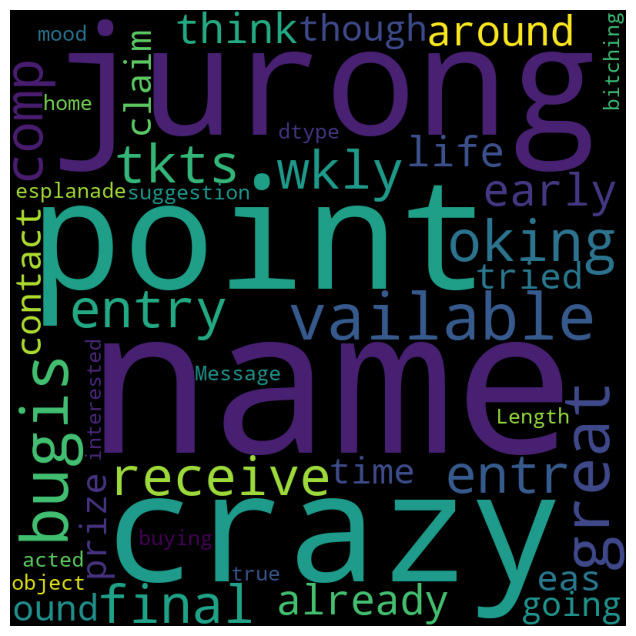

In [7]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 800, background_color = "black", max_words = 1000, min_font_size = 20, random_state = 42)\
    .generate(str(total_data["Message"]))

fig = plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

The last step before training the model is to convert it into numbers, since models cannot be trained with textual categories. In previous modules we saw how we could transform text into numeric vectors using the `CountVectorizer` of `scikit-learn`, but here we will apply a new process to provide more tools to the student:

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tokens_list = total_data["Message"]
tokens_list = [" ".join(tokens) for tokens in tokens_list]

vectorizer = TfidfVectorizer(max_features = 5000, max_df = 0.8, min_df = 5)
X = vectorizer.fit_transform(tokens_list).toarray()
y = total_data["Category"]

X[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

`TfidfVectorizer` converts a collection of raw text documents into a TF-IDF feature matrix. TF-IDF is a measure that quantifies the importance of a word in a document relative to a corpus. It is composed of two terms:

- **TF** (*Term Frequency*): it is the frequency of a word in a document.
- **IDF** (*Inverse Document Frequency*): Measures the importance of the term in the corpus. A term that appears in many documents may not be as informative.

Therefore, by using `TfidfVectorizer`, we transform a collection of text documents into a numerical matrix representing the relative importance of each word in each document, relative to the entire corpus. This matrix is commonly used as input for machine learning algorithms, especially in natural language processing tasks such as text classification.

##### Train test split

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#### Step 3: Initialization and training of the model

In [10]:
from sklearn.svm import SVC

model = SVC(kernel = "linear", random_state = 42)
model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

#### Step 4: Model prediction

Once the model has been trained, it can be used to predict with the test data set.

In [11]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

With raw data it is very difficult to know whether the model is getting it right or not. To do this, we must compare it with reality. There are a large number of metrics to measure the effectiveness of a model in predicting, including **accuracy**, which is the fraction of predictions that the model made correctly.

In [12]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.9748062015503876

#### Step 5: Saving the model

Once we have the model we were looking for (presumably after hyperparameter optimization), to be able to use it in the future it is necessary to store it in our directory, together with the seed.

In [13]:
from pickle import dump

dump(model, open("svm_classifier_linear_42.sav", "wb"))

Adding an explanatory name to the model is vital, since in the case of losing the code that has generated it we will know, on the one hand, what configuration it has (in this case we say `linear` because the kernel is linear) and also the seed to replicate the random components of the model, which in this case we do by adding a number to the file name, `42`.